In [110]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import roc_curve, auc

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [111]:
file_path_4 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/pro_data.csv' # cleaned data
df = pd.read_csv(file_path_4)
df['datadate'] = pd.to_datetime(df['datadate'])

# Replace inf and -inf with NaN
df.replace(['inf', '-inf', np.inf, -np.inf], np.nan, inplace=True)

df = df.dropna(subset=['relative_quarterly_return'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14322 entries, 1 to 15338
Data columns (total 42 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   gvkey                      14322 non-null  int64         
 1   datadate                   14322 non-null  datetime64[ns]
 2   tic                        14322 non-null  object        
 3   actq                       14322 non-null  float64       
 4   ancq                       14322 non-null  float64       
 5   epsfxq                     14302 non-null  float64       
 6   lctq                       14322 non-null  float64       
 7   ltq                        14322 non-null  float64       
 8   revtq                      14322 non-null  float64       
 9   capxy                      13783 non-null  float64       
 10  roa                        14289 non-null  float64       
 11  roe                        14097 non-null  float64       
 12  pe_i

In [112]:
df = df.dropna()
df = df.sort_values(by=['datadate'])

#df.to_csv('check_data.csv', index=False)  # Set index=False to exclude the index column

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6953 entries, 2164 to 3737
Data columns (total 42 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   gvkey                      6953 non-null   int64         
 1   datadate                   6953 non-null   datetime64[ns]
 2   tic                        6953 non-null   object        
 3   actq                       6953 non-null   float64       
 4   ancq                       6953 non-null   float64       
 5   epsfxq                     6953 non-null   float64       
 6   lctq                       6953 non-null   float64       
 7   ltq                        6953 non-null   float64       
 8   revtq                      6953 non-null   float64       
 9   capxy                      6953 non-null   float64       
 10  roa                        6953 non-null   float64       
 11  roe                        6953 non-null   float64       
 12  pe_

In [113]:
train_start_date = '1970-03-31'
valid_start_date = '2010-03-31'
test_start_date = '2012-03-31'

train_df = df[(df['datadate'] >= train_start_date) & (df['datadate'] < valid_start_date)]
valid_df = df[(df['datadate'] >= valid_start_date) & (df['datadate'] < test_start_date)]
test_df = df[(df['datadate'] >= test_start_date)]

In [114]:
drop_cols = ['gvkey', 'datadate', 'tic']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

train_df.head()

,actq,ancq,epsfxq,lctq,ltq,revtq,capxy,roa,roe,pe_inc,...,gpm_change,evm_change,cfm_change,npm_change,PEG_trailing_change,de_ratio_change,curr_ratio_change,ptb_change,relative_quarterly_return,target
2164,0.0,0.0,-0.200000,0.0,0.0,0.001427,0.0,0.134,0.155,48.364,...,0.00000,0.000000,0.0,0.000000,-0.313123,0.0,0.0,-0.212922,0.089687,-0.085145
2379,0.0,0.0,0.259259,0.0,0.0,0.032394,0.0,0.262,0.065,22.768,...,0.00000,0.000000,0.0,-0.013699,-0.291522,0.0,0.0,-0.247343,-0.158604,0.006660
2974,0.0,0.0,-0.142857,0.0,0.0,0.214003,0.0,0.171,0.018,13.424,...,0.00000,0.000000,0.0,0.000000,-0.135628,0.0,0.0,-0.195620,-0.007312,-0.052615
534,0.0,0.0,0.281250,0.0,0.0,0.000000,0.0,0.052,0.057,10.973,...,0.00000,0.000000,0.0,0.000000,-0.826635,0.0,0.0,-0.194570,0.062110,-0.384612
10936,0.0,0.0,-0.205607,0.0,0.0,-0.085379,0.0,0.231,0.146,26.250,...,0.01157,-0.028321,0.0,0.000000,7.552610,0.0,0.0,-0.174092,0.039697,-0.523746


In [115]:
y_train = train_df['target'].copy()
X_train = train_df.drop(['target',], 1)

y_valid = valid_df['target'].copy()
X_valid = valid_df.drop(['target',], 1)

y_test  = test_df['target'].copy()
X_test  = test_df.drop(['target',], 1)

X_train.head()

,actq,ancq,epsfxq,lctq,ltq,revtq,capxy,roa,roe,pe_inc,...,debt_ebitda_change,gpm_change,evm_change,cfm_change,npm_change,PEG_trailing_change,de_ratio_change,curr_ratio_change,ptb_change,relative_quarterly_return
2164,0.0,0.0,-0.200000,0.0,0.0,0.001427,0.0,0.134,0.155,48.364,...,0.000000,0.00000,0.000000,0.0,0.000000,-0.313123,0.0,0.0,-0.212922,0.089687
2379,0.0,0.0,0.259259,0.0,0.0,0.032394,0.0,0.262,0.065,22.768,...,0.000000,0.00000,0.000000,0.0,-0.013699,-0.291522,0.0,0.0,-0.247343,-0.158604
2974,0.0,0.0,-0.142857,0.0,0.0,0.214003,0.0,0.171,0.018,13.424,...,0.000000,0.00000,0.000000,0.0,0.000000,-0.135628,0.0,0.0,-0.195620,-0.007312
534,0.0,0.0,0.281250,0.0,0.0,0.000000,0.0,0.052,0.057,10.973,...,0.000000,0.00000,0.000000,0.0,0.000000,-0.826635,0.0,0.0,-0.194570,0.062110
10936,0.0,0.0,-0.205607,0.0,0.0,-0.085379,0.0,0.231,0.146,26.250,...,-0.020833,0.01157,-0.028321,0.0,0.000000,7.552610,0.0,0.0,-0.174092,0.039697


In [116]:
# Scaling
scaler = MinMaxScaler()

# Fit the scaler on the training/validation data
X_train_scaled = scaler.fit_transform(X_train)

# Now apply the same scaling to the val/test data using the already fitted scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled.head()

,actq,ancq,epsfxq,lctq,ltq,revtq,capxy,roa,roe,pe_inc,...,debt_ebitda_change,gpm_change,evm_change,cfm_change,npm_change,PEG_trailing_change,de_ratio_change,curr_ratio_change,ptb_change,relative_quarterly_return
0,0.15909,0.210483,0.425301,0.079621,0.210717,0.120850,0.206034,0.789714,0.302228,0.549319,...,0.081971,0.812683,0.786701,0.363636,0.588235,0.462345,0.131981,0.293763,0.076376,0.447383
1,0.15909,0.210483,0.430834,0.079621,0.210717,0.124959,0.206034,0.828667,0.264397,0.511076,...,0.081971,0.812683,0.786701,0.363636,0.588034,0.462399,0.131981,0.293763,0.072602,0.302853
2,0.15909,0.210483,0.425990,0.079621,0.210717,0.149057,0.206034,0.800974,0.244641,0.497115,...,0.081971,0.812683,0.786701,0.363636,0.588235,0.462784,0.131981,0.293763,0.078273,0.390920
3,0.15909,0.210483,0.431099,0.079621,0.210717,0.120661,0.206034,0.764760,0.261034,0.493453,...,0.081971,0.812683,0.786701,0.363636,0.588235,0.461077,0.131981,0.293763,0.078388,0.431331
4,0.15909,0.210483,0.425234,0.079621,0.210717,0.109331,0.206034,0.819233,0.298445,0.516278,...,0.081769,0.812765,0.785312,0.363636,0.588235,0.481774,0.131981,0.293763,0.080634,0.418284


In [117]:


%%time

parameters = {
    'n_estimators': [300, 400],
    'learning_rate': [0.05],
    'max_depth': [6, 8],
    'gamma': [0.01, 0.001],
    'random_state': [42]
}

eval_set = [(X_train_scaled, y_train), (X_valid_scaled, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train_scaled, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')



/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[18:48:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[18:48:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[18:48:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[18:48:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[18:48:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { 

KeyboardInterrupt: 

In [ ]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)

CPU times: user 19.3 s, sys: 1.06 s, total: 20.4 s
Wall time: 3.33 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.001, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

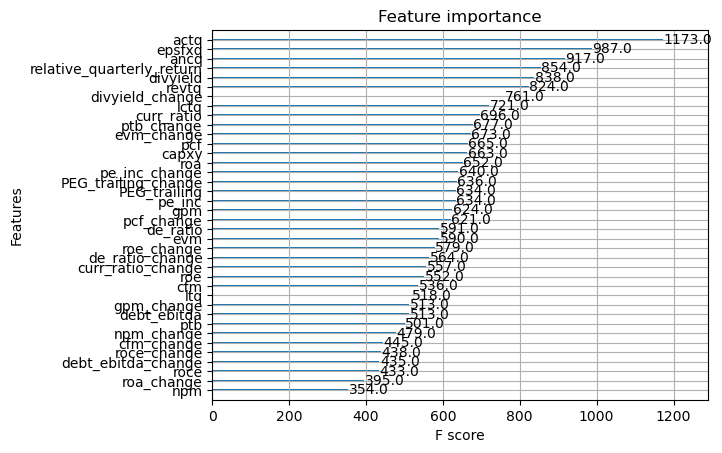

In [ ]:
plot_importance(model);

In [ ]:
# Predictions
y_train_pred = model.predict(X_train_scaled)
y_valid_pred = model.predict(X_valid_scaled)
y_test_pred = model.predict(X_test_scaled)

# Classifier
y_train_pred_binary = (y_train_pred >= 0).astype(int)
y_valid_pred_binary = (y_valid_pred >= 0).astype(int)
y_test_pred_binary = (y_test_pred >= 0).astype(int)

y_train_binary = (y_train >= 0).astype(int)
y_valid_binary = (y_valid >= 0).astype(int)
y_test_binary = (y_test >= 0).astype(int)

print(classification_report(y_test_binary, y_test_pred_binary))



              precision    recall  f1-score   support

           0       0.71      0.62      0.67       992
           1       0.66      0.74      0.70       956

    accuracy                           0.68      1948
   macro avg       0.69      0.68      0.68      1948
weighted avg       0.69      0.68      0.68      1948

